In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import nltk, os, re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/fake_newsdata.csv')

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()


,title,text,label
0,China tightens regulation of religion to 'bloc...,BEIJING (Reuters) - China s cabinet on Thursda...,TRUE
1,WOW! VIDEO CAPTURES Angry St. Louis Protesters...,"KTVI Fox 2, the TV station that appears to be ...",FAKE
2,North Korean envoy rejects Trump overture to m...,GENEVA (Reuters) - U.S. Republican presidentia...,TRUE
3,Republicans in House push for Congressional Bu...,WASHINGTON (Reuters) - Conservative Republican...,TRUE
4,Factbox: Contenders for key jobs in Trump's ad...,(Reuters) - U.S. President-elect Donald Trump ...,TRUE


In [ ]:
df.isna().sum()

,0
title,0
text,0
label,0


In [ ]:
df.head()

,title,text,label
0,China tightens regulation of religion to 'bloc...,BEIJING (Reuters) - China s cabinet on Thursda...,TRUE
1,WOW! VIDEO CAPTURES Angry St. Louis Protesters...,"KTVI Fox 2, the TV station that appears to be ...",FAKE
2,North Korean envoy rejects Trump overture to m...,GENEVA (Reuters) - U.S. Republican presidentia...,TRUE
3,Republicans in House push for Congressional Bu...,WASHINGTON (Reuters) - Conservative Republican...,TRUE
4,Factbox: Contenders for key jobs in Trump's ad...,(Reuters) - U.S. President-elect Donald Trump ...,TRUE


# **FEATURE ENGINEERING**

In [ ]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt_tab')

# Load dataset (Adjust path as needed)
df = pd.read_csv('/content/drive/MyDrive/fake_newsdata.csv')

# A. TOTAL NUMBER OF WORDS USED
df['nb_words'] = df['title'].apply(lambda x: len(x.split()))

#  B. TOTAL NUMBER OF UNIQUE WORDS USED
df['nb_unique_words'] = df['title'].apply(lambda x: len(set(x.split())))

#  C. TOTAL NUMBER OF CHARACTERS USED
df['nb_char'] = df['title'].apply(lambda x: len(x))

#  D. TOTAL SPECIAL CHARACTERS USED
df["nb_special"] = df['title'].apply(lambda x: sum(not char.isalpha() for char in x))

#  E. TOTAL NUMBER OF PUNCTUATION USED
def punct(text):
    return len([w for w in text if w in string.punctuation])
df['nb_punct'] = df['title'].apply(lambda x: punct(x))

#  F. TOTAL NUMBER OF STOPWORDS USED
stopword = set(stopwords.words('english'))
def stop(text):
    return len([w for w in text.split() if w in stopword])
df['nb_stopwords'] = df['title'].apply(lambda x: stop(x))

#  G. TOTAL NUMBER OF TITLE CASE WORDS USED
df['nb_title_case'] = df['title'].apply(lambda x: sum(1 for w in x.split() if w.istitle()))

#  H. TOTAL NUMBER OF UPPERCASE WORDS USED
df['nb_upper'] = df['title'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))

#  I. NUMBER OF MOST FREQUENT TERMS
token = nltk.word_tokenize(' '.join(df['title']))
frequent = nltk.FreqDist(token)
print(frequent.most_common(15))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


[(':', 13621), ('’', 13520), ('Trump', 13065), (',', 9779), ('to', 8962), ('To', 7568), ('s', 5886), ('”', 5468), ('VIDEO', 5354), ('[', 5239), (']', 5238), ('in', 5065), ('“', 5026), ('The', 4650), ('U.S.', 4283)]


In [ ]:
## REMOVING PUNCTUATION AND STOPWORDS FROM MOST FREQUENT WORDS
for sym in string.punctuation:
    del frequent[sym]
for word in stopword:
    del frequent[word]
frequent.most_common(15)

[('’', 13531),
 ('Trump', 10802),
 ('To', 7562),
 ('”', 5470),
 ('VIDEO', 5328),
 ('“', 5028),
 ('The', 4574),
 ("'s", 4154),
 ('For', 3963),
 ('In', 3570),
 ('Of', 3440),
 ('‘', 3438),
 ('Video', 2993),
 ('A', 2992),
 ('U.S.', 2930)]

In [ ]:
## J. NUMBER OF WORDS CONTAIN OUT OF MOST COMMON 100 WORDS
freq_words = list(dict(frequent.most_common()[:100]).keys())
def freq(text):
    return(len([w for w in text.split() if w in freq_words]))
df['nb_freq_words'] = df.title.apply(lambda x: freq(x))

In [ ]:
df.head()

,title,text,label,nb_words,nb_unique_words,nb_char,nb_special,nb_punct,nb_stopwords,nb_title_case,nb_upper,nb_freq_words
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,TRUE,10,10,64,12,3,1,3,1,3
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,TRUE,9,9,64,11,3,2,3,1,3
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,TRUE,10,10,60,15,6,2,6,1,2
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,TRUE,9,9,59,10,2,1,2,2,2
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,TRUE,11,11,69,12,2,2,4,0,3


In [ ]:
## K. NUMBER OF WORDS CONTAIN OUT OF MOST COMMON 100 WORDS
freq_words = list(dict(frequent.most_common()[:100]).keys())
def freq(text):
    return(len([w for w in text.split() if w in freq_words]))
df['nb_freq_words'] = df.title.apply(lambda x: freq(x))

In [ ]:
df.head()

,title,text,label,nb_words,nb_unique_words,nb_char,nb_special,nb_punct,nb_stopwords,nb_title_case,nb_upper,nb_freq_words,avg_freq_word
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,TRUE,10,10,64,12,3,1,3,1,3,0.300000
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,TRUE,9,9,64,11,3,2,3,1,3,0.333333
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,TRUE,10,10,60,15,6,2,6,1,2,0.200000
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,TRUE,9,9,59,10,2,1,2,2,2,0.222222
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,TRUE,11,11,69,12,2,2,4,0,3,0.272727


In [ ]:
## L. AVERAGE OF FREQ TERMS WITH TOTAL WORDS USED
freq_words = list(dict(frequent.most_common()[:100]).keys())
def freq(text):
    return(len([w for w in text.split() if w in freq_words])/len(text.split()))
df['avg_freq_word']= df.title.apply(lambda x: freq(x))

In [ ]:
df.head()

,title,text,label,nb_words,nb_unique_words,nb_char,nb_special,nb_punct,nb_stopwords,nb_title_case,nb_upper,nb_freq_words,avg_freq_word
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,TRUE,10,10,64,12,3,1,3,1,3,0.300000
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,TRUE,9,9,64,11,3,2,3,1,3,0.333333
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,TRUE,10,10,60,15,6,2,6,1,2,0.200000
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,TRUE,9,9,59,10,2,1,2,2,2,0.222222
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,TRUE,11,11,69,12,2,2,4,0,3,0.272727


## exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

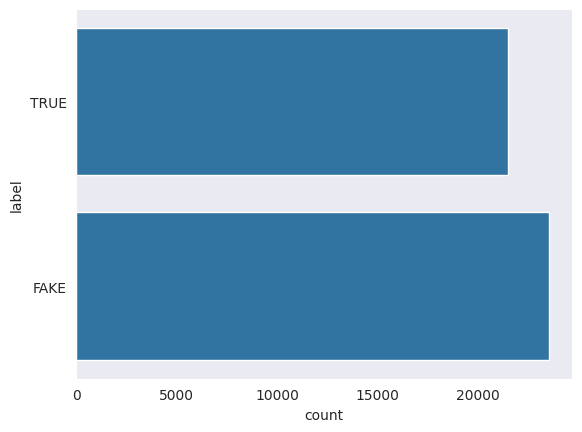

In [ ]:
sns.set_style("dark")
sns.countplot(df.label)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
df_fake = df[df['label']=='FAKE']
df_true = df[df['label']=='TRUE']

<Axes: ylabel='Frequency'>

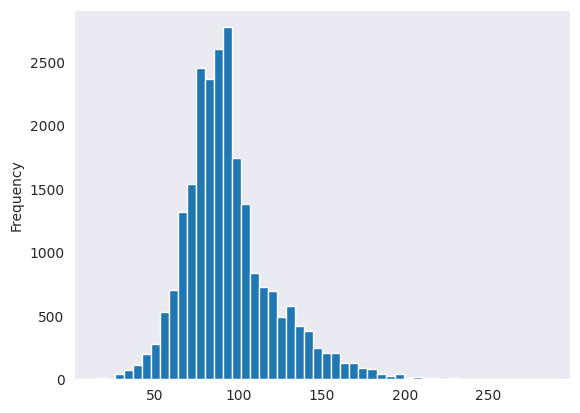

In [ ]:
df_fake['nb_char'].plot(bins=50, kind='hist')

In [ ]:
df_fake['nb_char'].describe()

,nb_char
count,23500.000000
mean,94.099362
std,27.271260
min,15.000000
25%,77.000000
50%,90.000000
75%,105.000000
max,286.000000


<Axes: ylabel='Frequency'>

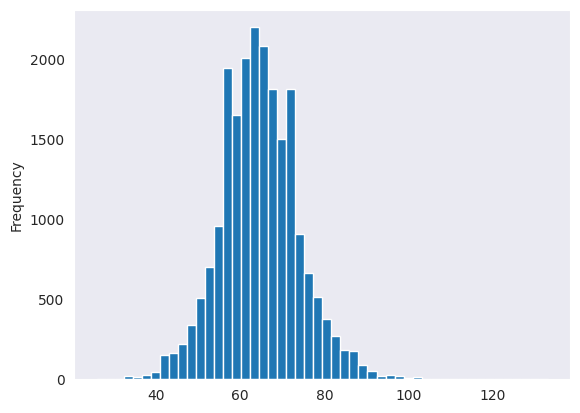

In [ ]:
df_true['nb_char'].plot(bins=50, kind='hist')

In [ ]:
df_true['nb_char'].describe()

,nb_char
count,21467.000000
mean,64.611730
std,9.235585
min,26.000000
25%,59.000000
50%,64.000000
75%,70.000000
max,133.000000


<Axes: ylabel='Frequency'>

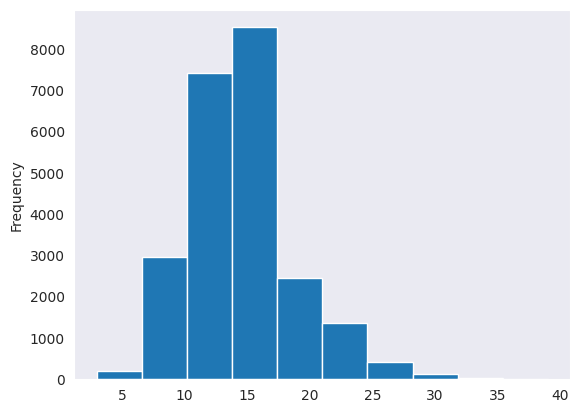

In [ ]:
df_fake['nb_unique_words'].plot(bins=10, kind='hist')

In [ ]:
df_fake['nb_unique_words'].describe()

,nb_unique_words
count,23500.000000
mean,14.481064
std,4.134410
min,3.000000
25%,12.000000
50%,14.000000
75%,16.000000
max,39.000000


<Axes: ylabel='Frequency'>

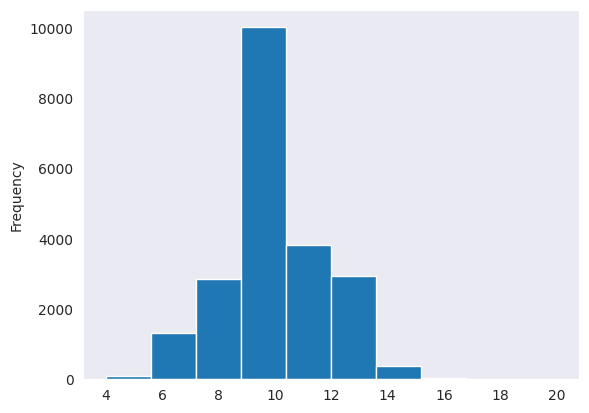

In [ ]:
df_true['nb_unique_words'].plot(bins=10, kind='hist')

In [ ]:
df_true['nb_unique_words'].describe()

,nb_unique_words
count,21467.000000
mean,9.866446
std,1.668682
min,4.000000
25%,9.000000
50%,10.000000
75%,11.000000
max,20.000000


### Observation:
As we can see average number of unique words in real headlines is relatively less in comparison to fake news

<ipython-input-37-8f214a38b0e6>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_fake['nb_words'])


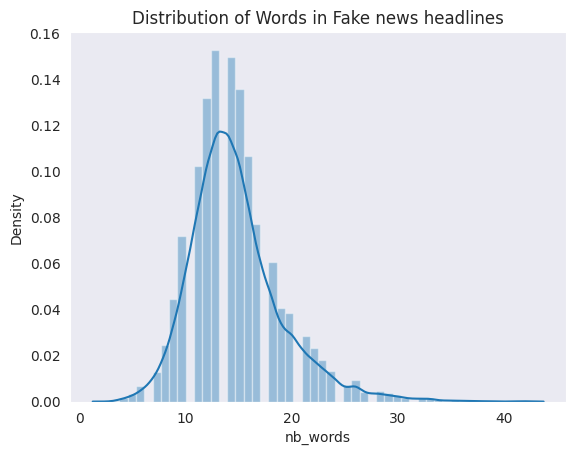

In [ ]:
# distribution of fake words in Headline
sns.distplot(df_fake['nb_words'])
plt.title("Distribution of Words in Fake news headlines")
plt.show()

<ipython-input-38-be22f592f457>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_true['nb_words'])


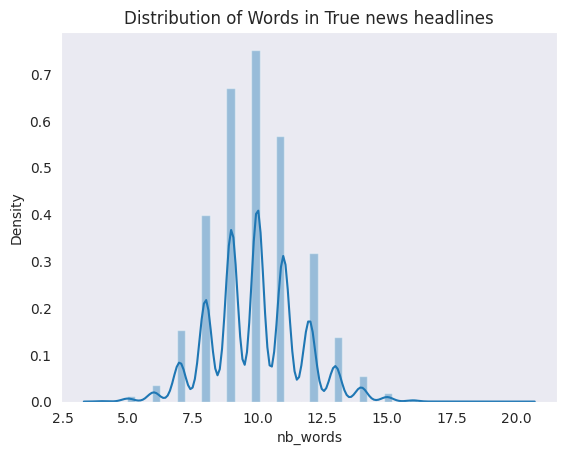

In [ ]:
# distribution of  words in Real news Headline
sns.distplot(df_true['nb_words'])
plt.title("Distribution of Words in True news headlines")
plt.show()

<ipython-input-39-c7116422d233>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_true['nb_special'])


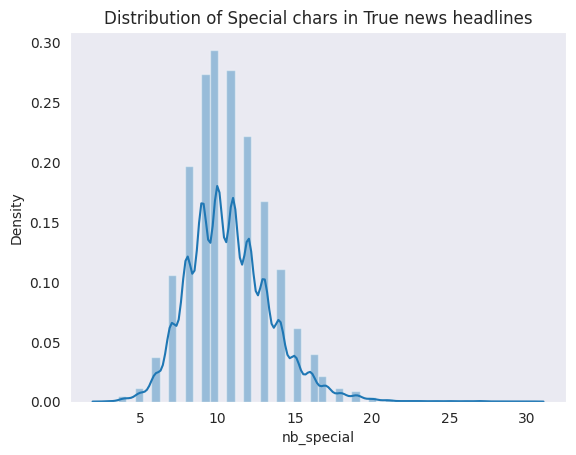

In [ ]:
# distribution of  special characters in Real news Headline
sns.distplot(df_true['nb_special'])
plt.title("Distribution of Special chars in True news headlines")
plt.show()

<ipython-input-40-b3491955b522>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_fake['nb_special'])


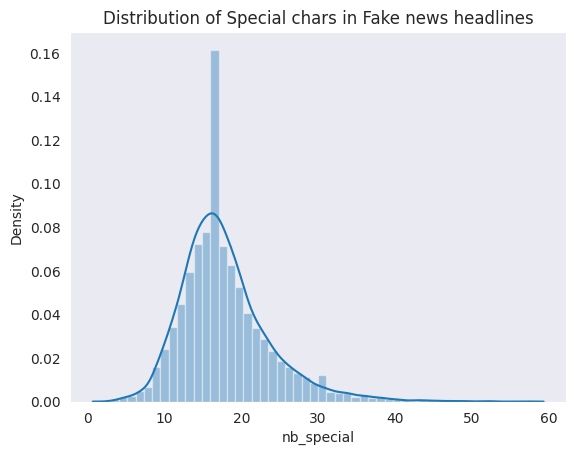

In [ ]:
# distribution of  special characters in Fake news Headline
sns.distplot(df_fake['nb_special'])
plt.title("Distribution of Special chars in Fake news headlines")
plt.show()

### Observation:
As we can see there are more special characters in fake news than real news because real news is generally to the point no superflous words or less use of special characters

In [ ]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Removing stop words which are unneccesary from headline news
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

df['title']=df['title'].apply(remove_stopwords)

## Plotting Wordcloud

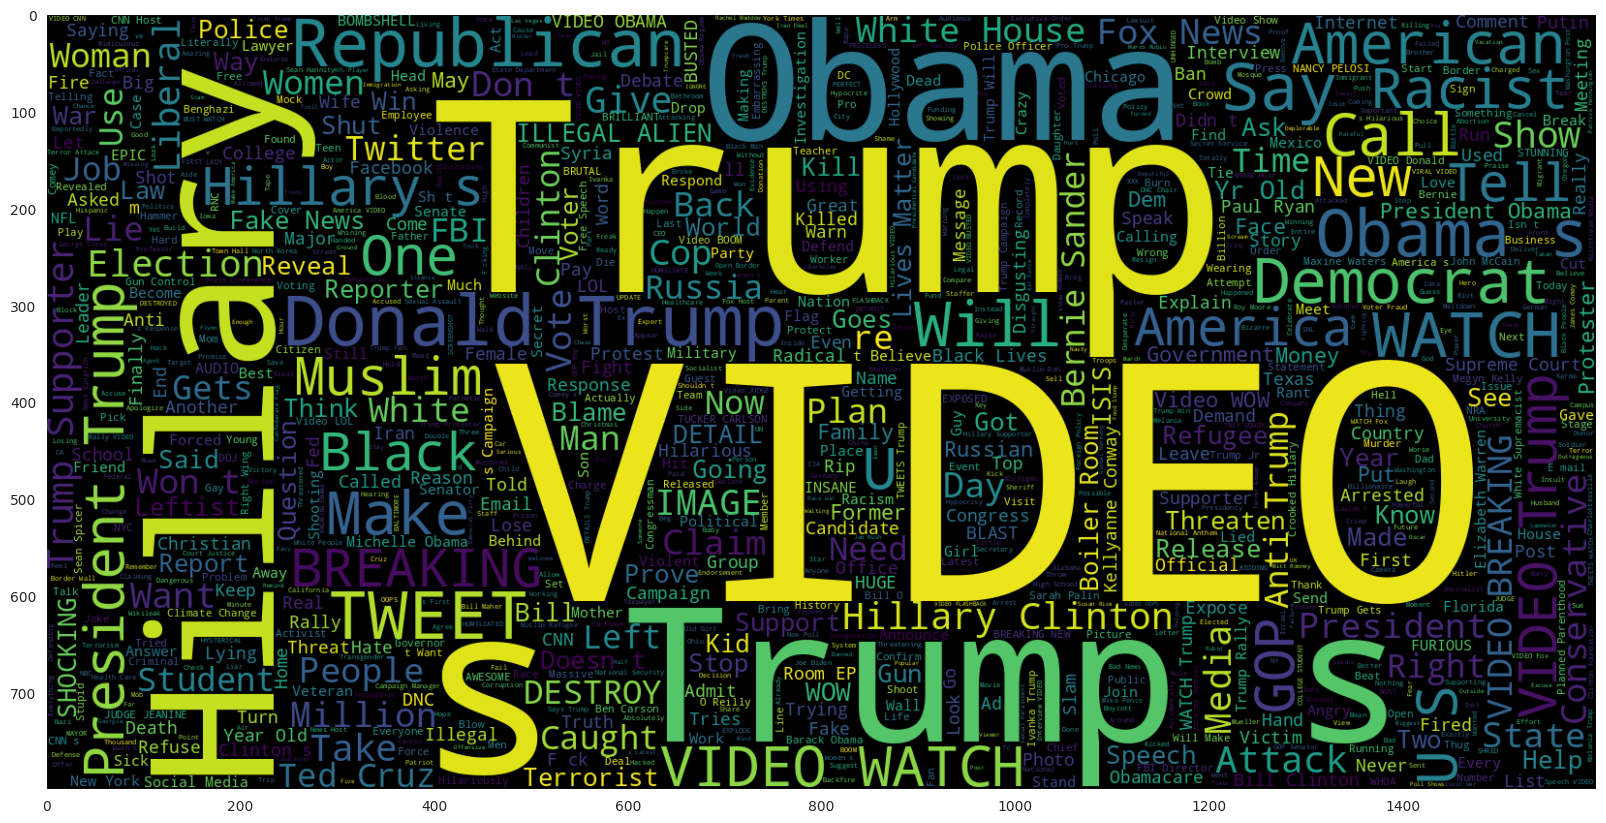

In [ ]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_fake.title))
plt.imshow(wc , interpolation = 'bilinear')

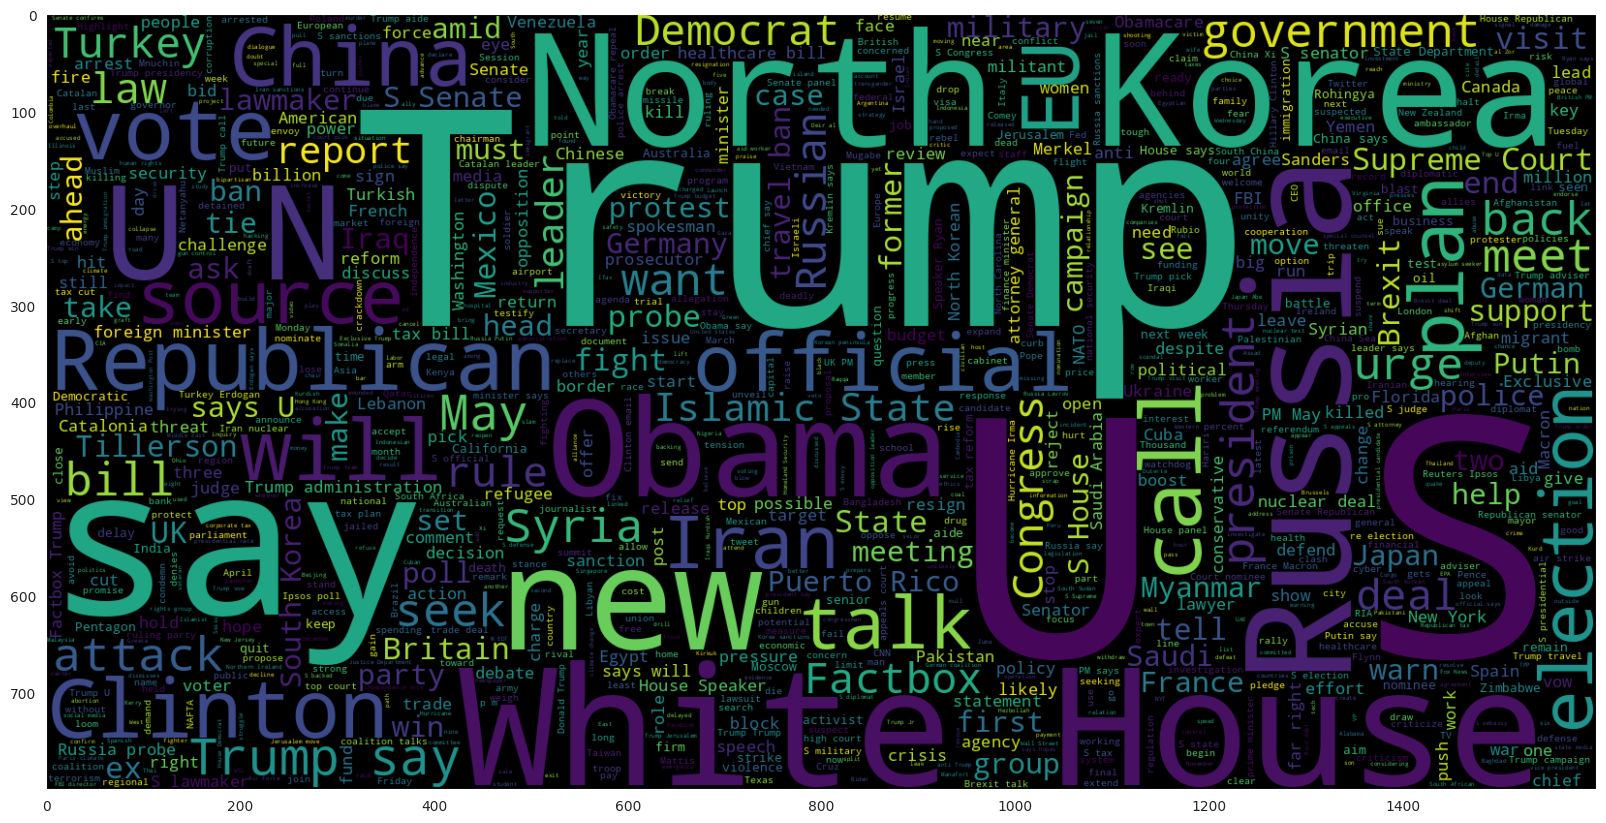

In [ ]:
plt.figure(figsize = (20,20)) # Text that is True News Headlines
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(df_true.title))
plt.imshow(wc , interpolation = 'bilinear')